ECE271B Project

Group3

Haoming Zhang, Guoren Zhong

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
import copy

# Read Data
print("Reading data")
d = pd.read_csv("Reviews.csv")  # https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv
pids, uids, scores, sums, texts = d["ProductId"].values, d["UserId"].values, d["Score"].values, d["Summary"].values, d["Text"].values
data = []
for i in range(len(d)):
    data.append((uids[i], pids[i], scores[i], sums[i], texts[i]))
random.shuffle(data)

# Split data into 70-10-20
train_len = int(len(data)*0.7)
val_len = int(len(data)*0.1)
test_len = len(data) - train_len - val_len
train = data[:train_len]
val = data[train_len:(train_len + val_len)]
test = data[(train_len + val_len):]
print("Done")

Reading data
Done


In [2]:
len(data)

568454

In [3]:
# Find the frequencies of users and books
userDict = defaultdict(int)
prodDict = defaultdict(int)
prodsPerUser = defaultdict(set)
usersPerProd = defaultdict(set)
users = set()
prods = set()
total_u = 0
total_p = 0
prodsRates = defaultdict(list)
for da in data: 
    userDict[da[0]] += 1
    prodDict[da[1]] += 1
    prodsPerUser[da[0]].add(da[1])
    usersPerProd[da[1]].add(da[0])
    prodsRates[da[1]].append(da[2])
    if da[0] not in users:
        users.add(da[0])
        total_u += 1
    if da[1] not in prods:
        prods.add(da[1])
        total_p += 1
for k in prodsRates.keys():
    prodsRates[k] = np.mean(prodsRates[k])


In [4]:
print(len(users))
print(len(prods))

256059
74258


In [5]:
def getTopEntries(dic, num):
    dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    x = []
    y = []
    i = 0
    for key in dic.keys():
        x.append(str(key))
        y.append(dic[key])
        i += 1
        if i > num:
            break
    return x, y

def getBotEntries(dic, num):
    dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}
    x = []
    y = []
    i = 0
    for key in dic.keys():
        x.append(str(key))
        y.append(dic[key])
        i += 1
        if i > num:
            break
    return x, y

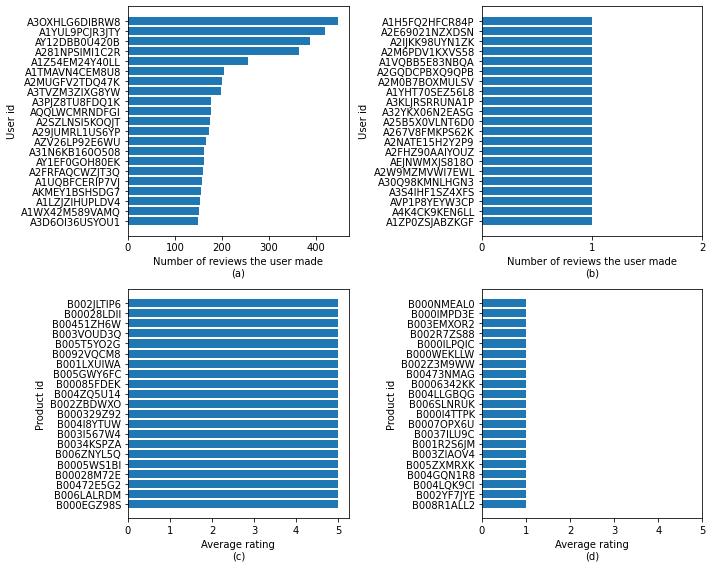

In [6]:
f = plt.figure(figsize=(10, 8))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

# Top 20 Reviewers who made most reviews
plt.sca(ax)
x, y = getTopEntries(userDict, 20)
ax.barh(x, y)
ax.set_xlabel("Number of reviews the user made\n(a)")
ax.set_ylabel("User id")
f.gca().invert_yaxis()

# Least 20 Reviewers who made most reviews
plt.sca(ax2)
x, y = getBotEntries(userDict, 20)
ax2.barh(x, y)
ax2.set_xlabel("Number of reviews the user made\n(b)")
ax2.set_ylabel("User id")
ax2.set_xticks(range(3))
f.gca().invert_yaxis()

# Top 20 rated books
plt.sca(ax3)
x, y = getTopEntries(prodsRates, 20)
ax3.barh(x, y)
ax3.set_xlabel("Average rating\n(c)")
ax3.set_ylabel("Product id")
f.gca().invert_yaxis()

# Least 20 rated books
plt.sca(ax4)
x, y = getBotEntries(prodsRates, 20)
ax4.barh(x, y)
ax4.set_xlabel("Average rating\n(d)")
ax4.set_ylabel("Product id")
ax4.set_xticks(range(6))
f.tight_layout()
f.gca().invert_yaxis()

In [9]:
X_train = []
X_val = []
y_train = []
y_val = []
totalRating = 0
ratePerUP = defaultdict(float)

for t in train:
    u, p = t[0], t[1]
    rate = t[2]
    X_train.append((u, p))
    y_train.append(rate)
    totalRating += rate
    ratePerUP[(u, p)] = rate
avgRate = totalRating/len(train)

for v in val:
    u, p = t[0], t[1]
    rate = v[2]
    X_val.append((u, p))
    y_val.append(rate)

Trivial Model(Predict by average)

In [11]:
from sklearn.metrics import mean_squared_error
import copy
y_pred_trivial = []
for v in X_val:
    u, p = v
    y_pred_trivial.append(avgRate)
trivial_mse = mean_squared_error(y_pred_trivial, y_val)
print("The MSE for trivial model is %f" %(trivial_mse))

The MSE for trivial model is 1.726596


Latent factor model

In [12]:
def gradientDescent(train, R, betaU0, alpha0, betaI0, lam, iter):
    diff = 1e-4
    alphas = [alpha0]
    for i in range(iter):
        if i % 5 == 0:
            print("iter = %d" % i, end=" ")
        indexes = (R != 0).astype(int)
        alpha = (np.sum(R) - np.sum(indexes@betaI0.reshape((-1,1))) - np.sum(betaU0.reshape((1,-1))@indexes))/len(train)  
        betaU = (np.sum(R,1).reshape((-1,1)) - (np.sum(indexes,1)*alpha).reshape((-1,1)) - indexes@betaI0.reshape((-1,1)))[:,0] / (lam+np.sum(indexes,1))
        betaI = (np.sum(R,0).reshape((1,-1)) - (np.sum(indexes,0)*alpha).reshape((1,-1)) - betaU.reshape((1,-1))@indexes)[0,:] / (lam + np.sum(indexes,0))
        alphas.append(alpha)

        difference = np.abs(alpha - alpha0)
        difference2 = np.abs(betaU0 - betaU)
        alpha0 = alpha 
        betaI0 = betaI 
        betaU0 = betaU
        if difference < diff:
            break
    return alphas, betaU, betaI

# Prediction on Validation set
def predictTime(val, alpha, bu, bi, u2index, b2index):
    y_pred = []
    for v in val:
        u, b = v[0], v[1]
        u_index = u2index[u]
        b_index = b2index[b]
        pred = alpha + bu[u_index] + bi[b_index]
        y_pred.append(pred)
    return y_pred

In [13]:
#build the training dataset
p2index = dict()
u2index = dict()
for i,p in enumerate(prods):
    p2index[p] = i 
for i,u in enumerate(users):
    u2index[u] = i    
num_user,num_prods = len(u2index),len(p2index)    
R = np.zeros((num_user,num_prods))
for u,p,r in train:
    R[u2index[u],p2index[p]] = r

MemoryError: Unable to allocate 142. GiB for an array with shape (256059, 74258) and data type float64

In [15]:
num_prods

74258

In [ ]:
mse_all = []
alpha_final = 0
bu_final = None
bi_final = None
minmse = float("inf")
for i in range(3, 4):
    # Initial values
    print("lambda = %d:" %(i))
    betaU0, alpha0, betaI0 = np.zeros(num_user), avgRate/len(train), np.zeros(num_books)
    alphas, bu, bi = gradientDescent(train, R, betaU0, alpha0, betaI0, i, 201)
    temp_pred = predictTime(val, alphas[-1], bu, bi, u2index, b2index)
    temp_mse = mean_squared_error(temp_pred, y_val)
    mse_all.append(temp_mse)
    if temp_mse < minmse:
        alpha_final = copy.deepcopy(alphas[-1])
        bu_final = copy.deepcopy(bu)
        bi_final = copy.deepcopy(bi)
        minmse = temp_mse
    print("Lambda = %d done. mse = %f" %(i, temp_mse))

In [ ]:
minlamb = np.argmin(mse_all)
plt.plot(mse_all)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE over lambda")
plt.show()
print("As shown in the graph, when lambda = %d, the MSE minimized: %f." %(minlamb+1, mse_all[minlamb]))

In [ ]:
y_test = []
for t in test:
    rate = t[2]
    y_test.append(rate)
test_pred = predictTime(test, alpha_final, bu_final, bi_final, u2index, b2index)
print("MSE for test set is %f" % mean_squared_error(test_pred, y_test))